In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
import json

In [3]:
from utils.imdb_ratings import movies_with_imdb_rating

# What isn't included in this notebook

This project required a lot of preprocessing, which is an interesting task, but is not related to the research questions. In this notebook we will focus on the research questions only.

For extracting characters and their attributes from the plot texts, refer to `extract_character_attributes.ipynb`.

For the clustering method please refer to `clustering.ipynb`, there you can find the methods comparison and the pipeline for characters clustering.

# Load the data

In [104]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )

movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)

actors = pd.read_csv(
    'data/MovieSummaries/character.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'release_date', 'character', 'date_of_birth', 'sex', 'height', '.','actor','age','character_map','..','...','....']
)

In [88]:
def same_name(names1, names2):
    names1 = names1.values
    names2 = names2.values
    flag = []
    for i in range(len(names1)):
        flag.append(names1[i] in names2[i])
    return flag


actors_and_characters = characters.merge(actors, how='left', left_on='wiki_id', right_on='wiki_id').dropna(subset=['character_y'])

actors_and_characters = actors_and_characters[same_name(actors_and_characters['character_x'], actors_and_characters['character_y'])]
actors_and_characters['character'] = actors_and_characters['character_x']
actors_and_characters = actors_and_characters.drop(columns=['character_x', 'character_y'])
actors_and_characters = actors_and_characters[['character', 'actor', 'wiki_id', 'release_date', 'date_of_birth', 'sex', 'height', 'age', 'adj', 'active', 'patient']]
actors_and_characters.sample(5)

,character,actor,wiki_id,release_date,date_of_birth,sex,height,age,adj,active,patient
174657,Saïd,Jamel Debbouze,5895236,2006-09-27,1975-06-18,M,1.65,31.0,[herder],"[join, become, make, mention, reach, befriend]",[kill]
676068,Maggie,Alice O'Connell,3208449,2005-11-18,NaN,F,NaN,NaN,[housekeeper],"[witness, know]",[]
660822,Jozef,Adelqui Migliar,22643293,1919-07-18,1891-08-05,M,NaN,NaN,[man],"[order, feel, receive, order, follow, wander, ...",[seduce]
435798,Richard Jacks,Timothy Daly,8154771,1995-02-04,1956-03-01,M,1.85,38.0,[],"[attend, receive, become, decide, look, return...",[warn]
669464,Joann,Candice Accola,24665719,2008-09-08,1987-05-13,F,1.73,21.0,"[girl, especially, object]","[show, tie, bite, escape, lie]","[ask, see, catch]"


In [105]:
map_dict_to_list = lambda x: [value for key, value in eval(x).items()]
release_year = lambda x: pd.to_numeric(x.str.replace(r'-\d{2}-\d{2}$', '', regex=True).str.replace(r'-\d{2}$', '', regex=True))

movies['languages'] = movies['languages'].apply(map_dict_to_list)
movies['countries'] = movies['countries'].apply(map_dict_to_list)
movies['genres'] = movies['genres'].apply(map_dict_to_list)

movies["release_year"] = release_year(movies['release_date'])
movies["release_year"] = movies['release_year'].apply(lambda x: x if x > 1800 else x + 1000)

movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],1983.0


In [6]:
%%script false --no-raise-error
# Script takes time to run, so we will use saved version instead
movies_with_rating = movies_with_imdb_rating(movies)

In [86]:
movies_with_rating = pd.read_csv(
    'data/movies_with_rating.csv', 
    index_col=0,
    converters={
        "languages": map_dict_to_list,
        "countries": map_dict_to_list,
        "genres": map_dict_to_list
        }
    )
    
movies_with_rating['release_year'] = release_year(movies_with_rating['release_date'])
movies_with_rating.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,averageRating,numVotes,release_year
0,10109752,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]",5.3,208,1894
1,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,NaN,[],[],[Sports],5.3,485,1897
2,142995,/m/0120y4,The Story of the Kelly Gang,1906-12-26,NaN,70.0,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,...",6.0,855,1906
3,32986669,/m/04p7yxx,Robbery Under Arms,1907-11-02,NaN,NaN,[Silent film],[Australia],"[Silent film, Drama]",4.3,25,1907
4,15128675,/m/03hjcy9,Hamlet,1908,NaN,NaN,[French Language],[France],"[Silent film, Drama]",2.9,27,1908


### First look at the data

In [8]:
print(f"Number of movies: {len(movies)}")
print(f"Number of movies with revenue: {movies['revenue'].notna().sum()}")
print(f"Number of movies with rating: {len(movies_with_rating)}")
print(f"Number of movies with rating and revenue: {movies_with_rating['revenue'].notna().sum()}")

Number of movies: 81741
Number of movies with revenue: 8401
Number of movies with rating: 39886
Number of movies with rating and revenue: 7339


In [28]:
print(f"Number of characters with archetypes: {len(characters)}")
print(f"Number of actors: {len(actors)}")
print(f"Number of actors with the characters who have an archetype: {len(actors_and_characters)}")

Number of characters with archetypes: 74842
Number of actors: 450669
Number of actors with the characters who have an archetype: 29724


In [29]:
print(f"Number of actors with the characters who have an archetype in the movies with revenue and rating: {len(actors_and_characters[actors_and_characters['wiki_id'].isin(movies_with_rating[movies_with_rating['revenue'].notna()]['wiki_id'])])}")

Number of actors with the characters who have an archetype in the movies with revenue and rating: 13839


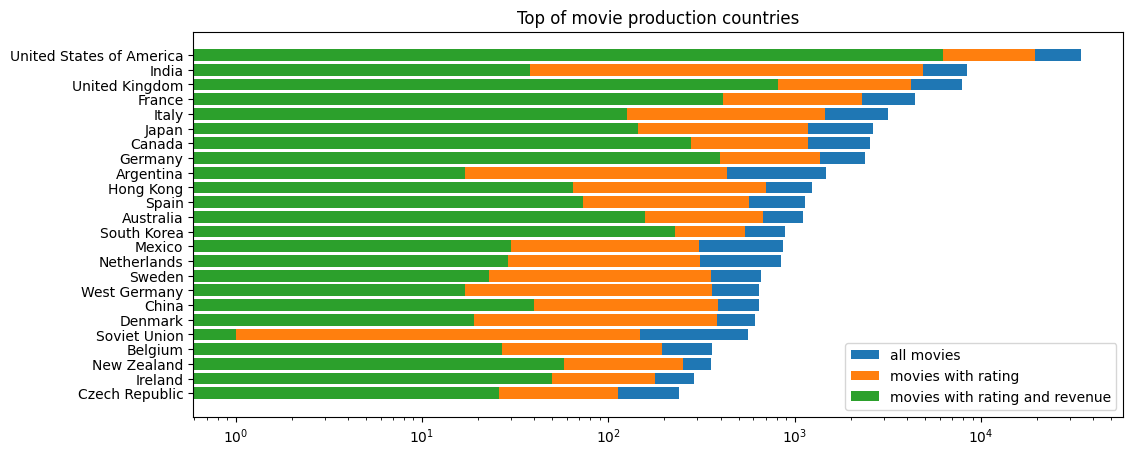

In [82]:
coutries_distr = movies.explode('countries').groupby('countries').size()
coutries_distr_with_rating = movies_with_rating.explode('countries').groupby('countries').size()
coutries_distr_with_rating_and_revenue = movies_with_rating[movies_with_rating['revenue'].notna()].explode('countries').groupby('countries').size()

coutries = list(set(
    coutries_distr.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating_and_revenue.sort_values(ascending=False)[:20].index.to_list()))

coutries_distr = coutries_distr.loc[coutries].sort_values(ascending=True)
coutries = coutries_distr.index.to_list() 
coutries_distr_with_rating = coutries_distr_with_rating.loc[coutries]
coutries_distr_with_rating_and_revenue = coutries_distr_with_rating_and_revenue.loc[coutries]

plt.figure(figsize=(12, 5))
plt.title('Top of movie production countries')

plt.barh(coutries_distr.index, coutries_distr.values, label='all movies')
plt.barh(coutries_distr_with_rating.index, coutries_distr_with_rating.values, label='movies with rating')
plt.barh(coutries_distr_with_rating_and_revenue.index, coutries_distr_with_rating_and_revenue.values, label='movies with rating and revenue')

plt.xscale('log')
plt.legend()

plt.show()

We can notice that most of the movies in the dataset are made in the US, moreover, we have much less data for movies with revenue and this data is't distributed prportionally to the overall number of movies produced in the country.

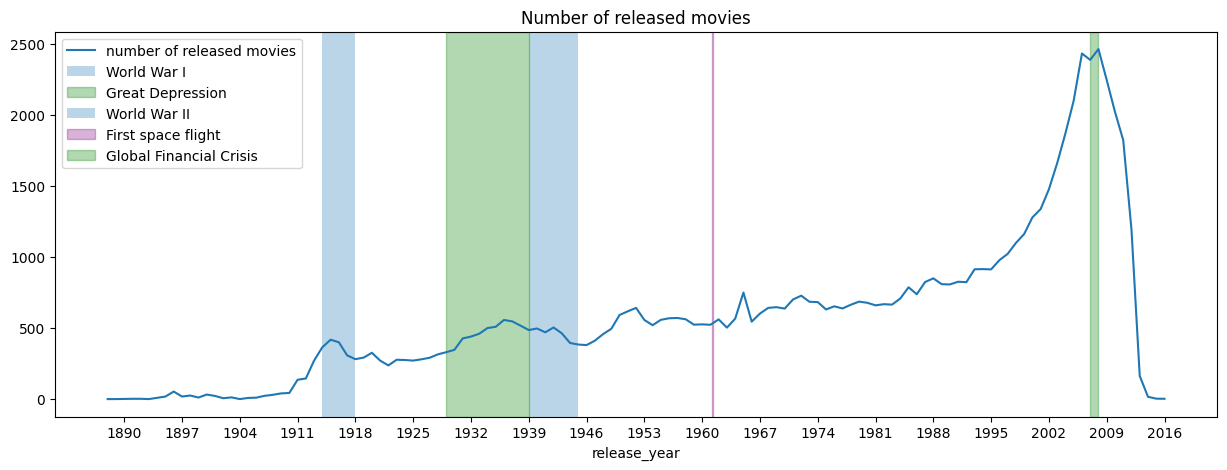

In [123]:
movies.groupby('release_year').size().plot(figsize=(15, 5), title='Number of released movies', label='number of released movies')
plt.xticks(np.arange(1890, 2021, 7))

plt.axvspan(1914, 1918, alpha=0.3, label='World War I')
plt.axvspan(1929, 1939, alpha=0.3, label='Great Depression', color='green')
plt.axvspan(1939, 1945, alpha=0.3, label='World War II')
plt.axvspan(1961.2, 1961.3, alpha=0.3, label='First space flight', color='purple')
plt.axvspan(2007, 2008, alpha=0.3, label='Global Financial Crisis', color='green')

plt.legend()

plt.show()

We don't have much data before 1910-s and after 2012.

# Clusters interpretation

# Historycal trends

# Cultural preference

# Movie success based on the archetypes

# Actors success based on the archetypes